In [878]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
from statistics import mode
import copy
import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

IMAGE_PATH='../sankey_diagram/group_graph'
GROUP_CNT = 5
PADDING = 2
POINT_CLOUD_DURATION = 1538
THRESHOLD = 2

OPACITY = 0.6

# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "Red", # read
            "vol": "Gold", # yellow
            "contact_map": "Tomato",
            "point_cloud": "OrangeRed",
            "addr": "LimeGreen", # green
            # "addr": "SkyBlue", # blue
            # "logical_addr": "SkyBlue", #light blue
            # "logical_addr_vfd": "PowderBlue", # slightly different light lue
            "file": "MediumBlue", # blue
            "none": "grey",
            }

# color names: https://www.w3schools.com/colors/colors_names.asp
# EDGE_COLOR_MAP = {"create": "rgba(128, 128, 128, 0.7)", # grey
#             "get": "rgba(128, 128, 128, 0.7)", #grey
#             "open": "rgba(128, 128, 128, 0.7)", # grey
#             "close": "rgba(128, 128, 128, 0.7)", # grey
#             "none": "rgba(128, 128, 128, 0.7)", # grey
#             "read": "rgba(221, 120, 221,0.7)", # light megenta
#             "write": "rgba(147, 112, 219, 0.7)", # light purple
#             }

EDGE_COLOR_RGBA = {
    'none' : {'r':180, 'g':180, 'b':180}, #grey for open/close/meta
    'read' : {'r':150, 'g':190, 'b':220},
    'write' : {'r':150, 'g':190, 'b':220},
    # 'read' : {'r':220, 'g':220, 'b':220},
    # 'write' : {'r':140, 'g':210, 'b':220},
}

NODE_LABEL=False


## Add time for group when duration is collected

1. Use the first appeared node node for time stamp / or least of time --> set _x position with first time
2. Calculate duration directly in dataframe
3. Sum duration to get edge time elaps, remove POINT_CLOUD_DURATION 
4. calculate BW from access size and time,
5. distribute color range, with large BW deep color, and small BW light color

### Current
1. Use the first appeared node node for time stamp / or least of time --> set _x position with first time
2. Record the last appeared node time stamp / or largest of time
3. calculate BW from access size and time, / 
4. distribute color range, with large BW deep color, and small BW light color \

In [879]:
# data related methods
def humansize(nbytes):
    if nbytes != 0:
        suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')

        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def humanbw(nbytes):
    if nbytes != 0:
        suffixes = ['B/s', 'KB/s', 'MB/s', 'GB/s', 'TB/s', 'PB/s']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

def get_min_max_loc(G):
    ret_dict = {}
    attr_dict = nx.get_node_attributes(G,'pos')
    min_x = min(attr_dict.values())[0]
    max_x = max(attr_dict.values())[0]
    for k,v in attr_dict.items():
        if v[0] == min_x:
            ret_dict['min'] = { k:v }
        if v[0] == max_x:
            ret_dict['max'] = { k:v }
    return ret_dict

In [880]:
# networkx related methods



def rm_name_tags(name, tags):
    for t in tags:
        name = str(name).replace(f"{t}-","")
        name = str(name).replace("vol-","")
        name = str(name).replace("contact_map","cm")
        name = str(name).replace("point_cloud","pc")
    return name

def draw_graph(G,color_map=COLOR_MAP, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        _n = rm_name_tags(name, rm_tags)
        node_colors.append(color_map[_n])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = rm_name_tags(node, rm_tags)
        labels[node] = _n

    plt.figure(figsize=(15, 5)) #figsize=(40, 10)
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges)
    # for edge in G.edges(data='access_cnt'):
    #     nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    
    plt.axis("off")
    plt.margins(x=0.1)
    
    out_tag = '-'.join(rm_tags)
    plt.savefig(f"{IMAGE_PATH}/networkx-grouped-{out_tag}.png") #different name
    
    plt.show()


In [881]:
'''
Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'logical_addr_vol', 'op_type_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'logical_addr_vfd', 'next_addr', 'op_type_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd', 'io_idx_vfd'],
      dtype='object')
      '''

def create_split_tags(df, gc,x_pos):
    #  create tags for the user-defined groups
    
    # split vol groups
    dsets = list(set(df['dset_name']))
    vol_group_map = {}
    vol_maxd = df.groupby('dset_name')['object_idx_vol'].max().to_dict()
    
    rank = 0
    
    for ds in dsets:
        gdset_order = x_pos #+PADDING
        maxval = int(vol_maxd[ds])
        step = math.ceil(maxval/gc)
        if step == 0:
            step = 1
            vol_group_range = []
        else:
            vol_group_range = list(range(0,maxval,step))
            vol_group_range.pop(0)
        
        if maxval not in vol_group_range:
            vol_group_range.append(maxval+1)
            
        vol_group_map[ds] = {}
        # add metadata (first-appeared) rank and ranges
        vol_group_map[ds][f'{ds}-[-1,0)'] = {}
        vol_group_map[ds][f'{ds}-[-1,0)']['range'] = (-1,0)
        vol_group_map[ds][f'{ds}-[-1,0)']['rank'] = rank #0
        rank+=1
        vol_group_map[ds][f'{ds}-[-1,0)']['gdset_order'] = gdset_order #0
        gdset_order+=1
        
        prev = 0
        for index, bnd in enumerate(vol_group_range):
            if index+1 == len(vol_group_range) and index !=0:
                group_name = f'{ds}-[{prev},{bnd-1})'
            else:
                group_name = f'{ds}-[{prev},{bnd})'
            vol_group_map[ds][group_name] = {}
            vol_group_map[ds][group_name]['range'] = (prev, bnd)
            vol_group_map[ds][group_name]['rank'] = rank
            rank+=1
            vol_group_map[ds][group_name]['gdset_order'] = gdset_order
            gdset_order+=1
            prev = bnd
            
    return vol_group_map

def split_consecutive(l):
    # setl = set(l)
    prev = l[0]
    rls = []
    rl = [prev]

    for n in l:
        if abs(n - prev) > THRESHOLD:            
            rl.append(prev)
            tmp_rl = copy.deepcopy(rl)
            tmp_rl = list(set(tmp_rl))
            unique_list = True
            for l in rls: 
                if tmp_rl == l: unique_list = False
            if unique_list:
                rls.append(tmp_rl)
            rl = []
        else:
            rl.append(prev)
        prev = n
    # len(l) == len(setl) and setl == set(range(min(l), max(l)+1))
    rl.append(prev)
    tmp_rl = copy.deepcopy(rl)
    tmp_rl = list(set(tmp_rl))
    unique_list = True
    for l in rls: 
        if tmp_rl == l: unique_list = False
    if unique_list:
        rls.append(tmp_rl)

    return rls

def is_contiguous(l):
    # setl = set(l)
    # return len(l) == len(setl) and setl == set(range(min(l), max(l)+1))
    contiguous = True
    prev = l[0]
    for n in l:
        if abs(n - prev) > THRESHOLD:
            contiguous = False
    return contiguous


def get_vol_group_addr(x):

    min_addr = int(x['logical_addr_vfd'].min())
    max_addr = int(x['logical_addr_vfd'].max())

    if min_addr == 0:
        addr_list = list(x['logical_addr_vfd'])
        if is_contiguous(list(x['io_idx_vol'])) == False:
            # print(x)
            # print(f"addr_list notcont = {addr_list}")
            # print(f"addr_list = {addr_list}")
            _addr_list = [i for i in addr_list if i != max_addr]
            # print(f"addr_list-- = {addr_list}")
        
            # if _addr_list:
            second_max = max(_addr_list)
            return {f'{x.name}' : [min_addr, second_max],
                    f'{x.name}-1' : [max_addr]}
        else:
            # print(f"addr_list contig = {addr_list}")
            return {f'{x.name}' : [min_addr, max_addr]}
    else:
        # if min_addr == 0:
        #     print(list(x['logical_addr_vfd']))
        return {f'{x.name}' : [min_addr, max_addr]}


    
def get_vfd_group_rank(x):
    rank = int(x['io_idx_vfd'].min())
    return rank

def map_split_tags(df,gc=GROUP_CNT, x_pos=0):
    # map user-selected groups tags to vol accesses
    vol_rmap = create_split_tags(df,gc,x_pos) #, vfd_rmap 
    # g: group, y: y-position, o: order
    vol_glist = []
    vol_y_list = []
    vol_olist = []

    for idx, row in df.iterrows():
        ds = row['dset_name']
        curr_idx = row['object_idx_vol']
        for k,v in vol_rmap[ds].items():
            if curr_idx >= v['range'][0] and curr_idx < v['range'][1]:
                vol_glist.append(k)
                vol_y_list.append(v['rank'])
                vol_olist.append(v['gdset_order'])
    
    df['group_vol'] = vol_glist
    df['group_y_vol'] = vol_y_list
    df['gdset_order'] = vol_olist

    # 
    vol_vfd_dlist = df.groupby('group_vol').apply(get_vol_group_addr).to_list()
    vol_vfd_dict = {}
    more_meta_label = {}
    for d in vol_vfd_dlist:
        vol_vfd_dict.update(d)
        for k,v in d.items():
            if len(v) == 1:
                more_meta_label[v[0]] = k
    # convert address to string
    for vol_label, addr in vol_vfd_dict.items():
        vol_vfd_dict[vol_label] = f'{addr}'
    
    df['group_vfd'] = df['group_vol'].map(vol_vfd_dict)
    df.replace({"group_vfd":vol_vfd_dict})
    for addr, vfd_label in more_meta_label.items():
        df.loc[df['logical_addr_vfd'] == addr, 'group_vfd'] = f'{[addr]}'
    
    print(vol_vfd_dict)

    vfd_y_dlist = df.groupby('group_vfd').apply(get_vfd_group_rank).to_dict()
    vfd_y_map = {key: rank for rank, key in enumerate(sorted(vfd_y_dlist, key=lambda x:x[1], reverse=False), 1)}
    df['group_y_vfd'] = df['group_vfd'].map(vfd_y_map)
    print(vfd_y_map)

    # pd.set_option('display.max_rows', None)
    # print(df.head(10))
    return df
    

In [882]:
from re import X


def get_asize(x,gtag):
    _sizes = list(set(x[f'access_size_{gtag}']))
    # return 1st should be same as the rest
    # vol access size is 0 for meta, use 1 for dummy
    # size = 1
    if len(_sizes) > 0:
        if _sizes[0] != 0:
            return _sizes[0]
    return 0

def get_edge_attributes(x,sname,tag,time_dict,reversed=False):
    attr_dict = {}
    gtag = tag.split('-')[-1]
    if gtag == 'addr': gtag = 'vfd'
    
    node_name = f'{tag}-{x.name}'
    # print(f"node_name = {node_name}")
    # print(f"time_dict = {time_dict}")
    time_elaps = time_dict[x.name][1] - time_dict[x.name][0]
    
    edge = (sname,node_name)
    if reversed: edge = (node_name,sname)
    
    attr_dict[edge] = {}
    # get access_size and cnt
    # access_size unique to io_idx
    tmp_dict = x.groupby(f'io_idx_{gtag}').apply(get_asize, gtag=gtag).to_dict()
    all_acc_size = []
    for k,v in tmp_dict.items():
        if v: all_acc_size.append(v)

    # print(all_acc_size)
    access_size = sum(all_acc_size)
    attr_dict[edge]['access_size'] = access_size
    if time_elaps == 0:
        time_elaps = POINT_CLOUD_DURATION # TODO: collect duration to remove thsi
    attr_dict[edge]['bandwidth'] = access_size/(time_elaps/1000000)

    # access_cnt unique to io_idx
    attr_dict[edge]['access_cnt'] = x.groupby(f'io_idx_{gtag}').ngroups

    # get operation of group
    try:
        op = mode(list(x[f'operation_vfd']))
        # if op == 'open':
        #     print(x)
    except:
        op = list(x[f'operation_vfd'])[0]
        # print(Counter(x[f'operation_vfd']))
        
    attr_dict[edge]['operation'] =  op #only 1
    return attr_dict

def get_node_x_pos(x,tag):
    x_start = min(x[f'time(us)_{tag}'])  #+PADDING
    x_end = max(x[f'time(us)_{tag}']) #+PADDING
    # node = x.name
    return (x_start, x_end)

def rank_node_x(node_pos_dict,x_pos=0):
    # rank x with all time values\
    new_dict = {}
    all_time = []
    for t in node_pos_dict.values():
        all_time.append(t[0])
        all_time.append(t[1])
    time_rank = stats.rankdata(all_time,method='dense')
    time_rank = [x+x_pos for x in time_rank]
    time_rank_map = dict(zip(all_time,time_rank))
    # print(time_rank_map)

    for k,v in node_pos_dict.items():
        x_start = time_rank_map[v[0]]
        x_end = time_rank_map[v[1]]
        new_dict[k] = (x_start, x_end)
    
    return new_dict

def add_edges_one2many(G,df,c1,c2, x_pos=0, tags=['','']):
    # in the case of task to vol or file to addr
    _x = x_pos
    gtag = c2.split('_')[-1] # tags[1].split('-')[-1]
    
    # add first node
    sname = f'{tags[0]}-{c1}'
    G.add_node(sname, pos=(_x,0), name=tags[0])

    # get x positions for group-nodes
    node_time_dict = df.groupby(c2).apply(get_node_x_pos, tag=gtag)
    node_time_dict = node_time_dict.to_dict()
    node_x_dict = rank_node_x(node_time_dict,x_pos)
    # add many nodes and edges
    tags_y_dict = dict(zip(df[c2],df[f'group_y_{gtag}']))
    gdset_order_dict = dict(zip(df[c2],df['gdset_order']))
    edges = []
    for k,v in tags_y_dict.items():
        # k=group_vol, v=group_y_vol
        node_name = f'{tags[1]}-{k}'
        _x = node_x_dict[k][1] + PADDING # use the end time
        # print(f"{k} = {node_x_dict[k]}")
        time_elaps_us = node_time_dict[k][1] - node_time_dict[k][0]
        G.add_node(node_name, pos=(_x,v), name=tags[1], 
            time_elaps_us=time_elaps_us, 
            group=gdset_order_dict[k])

    attr_dict = df.groupby(c2).apply(get_edge_attributes, 
        sname=sname, tag=tags[1],
        time_dict=node_time_dict).to_dict()
        
    attr_dict = {k: v for d in attr_dict.values() for k, v in d.items()}
    # add edges:
    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)

def add_edges_many2one(G,df,c1,c2, x_pos=0, tags=['','']):
    # in the case of addr to file for vol to task
    _x = x_pos
    gtag = c1.split('_')[-1] #tags[0].split('-')[-1]
    # if gtag == 'addr': gtag = 'vfd'

    # get x positions for group-nodes
    node_time_dict = df.groupby(c1).apply(get_node_x_pos, tag=gtag)
    node_time_dict = node_time_dict.to_dict()
    node_x_dict = rank_node_x(node_time_dict,x_pos)
    # print(node_x_dict)

    # add many nodes and edges
    tags_y_dict = dict(zip(df[c1],df[f'group_y_{gtag}']))
    gdset_order_dict = dict(zip(df[c1],df['gdset_order']))
    for k,v in tags_y_dict.items():
        # k=group_vol, v=group_y_vol
        node_name = f'{tags[0]}-{k}'
        _x = node_x_dict[k][1] #use the end time
        time_elaps_us = node_time_dict[k][1] - node_time_dict[k][0]
        G.add_node(node_name, pos=(_x,v), name=tags[0], 
            time_elaps_us=node_time_dict, 
            group=gdset_order_dict[k])
    
    _x = max(list(node_x_dict.values()), key = lambda t: t[1])[1] # ordered by end time
    # add last node
    sname = f'{tags[1]}-{c2}'
    G.add_node(sname, pos=(_x + PADDING*4,0), name=tags[1])

    attr_dict = df.groupby(c1).apply(get_edge_attributes, 
        sname=sname, tag=tags[0], 
        time_dict=node_time_dict, reversed=True).to_dict()

    attr_dict = {k: v for d in attr_dict.values() for k, v in d.items()}
    # add edges:
    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)

def sec_group(x,sec_c,tags,time_dict):
    sname = f'{tags[0]}-{x.name}'
    # tmp_dict = x.groupby(sec_c).apply(get_edge_attributes, sname =sname, tag=tags[0], reversed=True).to_dict()
    tmp_dict = x.groupby(sec_c).apply(get_edge_attributes, 
        sname =sname, tag=tags[1],
        time_dict=time_dict).to_dict()
    # print(tmp_dict)
    return tmp_dict

def add_edges_many2many(G,df,c1,c2, tags=['','']):
    # in the case of mapping between vol and vfd
    # usually c1-group_vol, c2-group_vfd
    # _x = x_pos
    # _y = 0
    gtag = c2.split('_')[-1]

    node_time_dict = df.groupby(c2).apply(get_node_x_pos, tag=gtag)
    node_time_dict = node_time_dict.to_dict()
    # add edges
    attr_list = df.groupby(c1).apply(sec_group, sec_c=c2, tags=tags, time_dict=node_time_dict).to_list()
    attr_dict = {}
    for part_dict in attr_list:
        tmp_list = list(part_dict.values())
        for d in tmp_list:
            attr_dict.update(d)

    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)


Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd', 'file_name',
       'time(us)_vfd', 'operation_vfd', 'io_idx_vfd'],
      dtype='object')
{'contact_map-[-1,0)': '[0, 1072]', 'contact_map-[-1,0)-1': '[37261376]', 'contact_map-[0,200)': '[1400, 7392752]', 'contact_map-[200,400)': '[7430280, 14841376]', 'contact_map-[400,600)': '[14878248, 22287656]', 'contact_map-[600,800)': '[22325224, 29737768]', 'contact_map-[800,1000)': '[29774984, 37224016]', 'point_cloud-[-1,0)': '[0, 1072]', 'point_cloud-[-1,0)-1': '[37261376]', 'point_cloud-[0,1)': '[37261648, 37261648]'}
{'[0, 1072]': 1, '[1400, 7392752]': 2, '[14878248, 22287656]': 3, '[22325224, 29737768]': 4, '[29774984, 37224016]': 5,

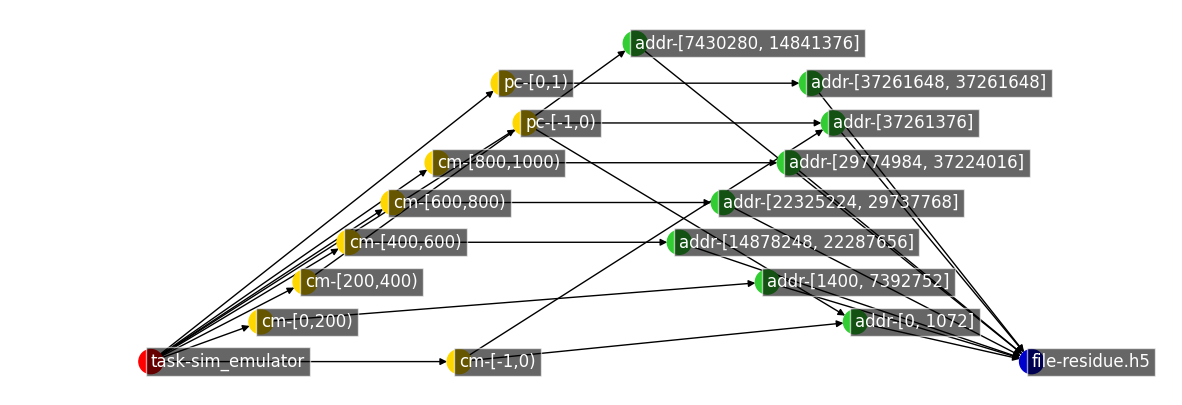

In [883]:
fsim='../sankey_diagram/dataframes/prov-vfd-sim-merged.csv'

df_sim_merged = read_data(fsim)

print(df_sim_merged.columns)

df_sim_merged = map_split_tags(df_sim_merged,GROUP_CNT)

G_SIM = nx.DiGraph()

add_edges_one2many(G_SIM,df_sim_merged, 'sim_emulator', 'group_vol', x_pos=0, tags=['task','sim-vol'])
x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0] +1
add_edges_many2one(G_SIM,df_sim_merged, 'group_vfd', 'residue.h5', x_pos=x_pos, tags=['sim-addr','file'])
add_edges_many2many(G_SIM,df_sim_merged, 'group_vol', 'group_vfd', tags=['sim-vol','sim-addr'])

# print(get_min_max_loc(G_SIM))
# print(nx.get_node_attributes(G_SIM,'time_elaps_us'))
# print(nx.get_node_attributes(G_SIM,'group'))

draw_graph(G_SIM,COLOR_MAP,rm_tags=['sim'])


{'contact_map-[-1,0)': '[0, 800]', 'contact_map-[-1,0)-1': '[1072]', 'contact_map-[0,200)': '[1400, 7396848]', 'contact_map-[200,400)': '[7430280, 14845472]', 'contact_map-[400,600)': '[14878248, 22291752]', 'contact_map-[600,800)': '[22325224, 29741864]', 'contact_map-[800,1000)': '[29774984, 37228112]', 'point_cloud-[-1,0)': '[0, 1072]', 'point_cloud-[-1,0)-1': '[37261376]', 'point_cloud-[0,1)': '[37261648, 37261648]'}
{'[0, 1072]': 1, '[0, 800]': 2, '[1072]': 3, '[1400, 7396848]': 4, '[14878248, 22291752]': 5, '[22325224, 29741864]': 6, '[29774984, 37228112]': 7, '[37261376]': 8, '[37261648, 37261648]': 9, '[7430280, 14845472]': 10}
Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'next_addr'

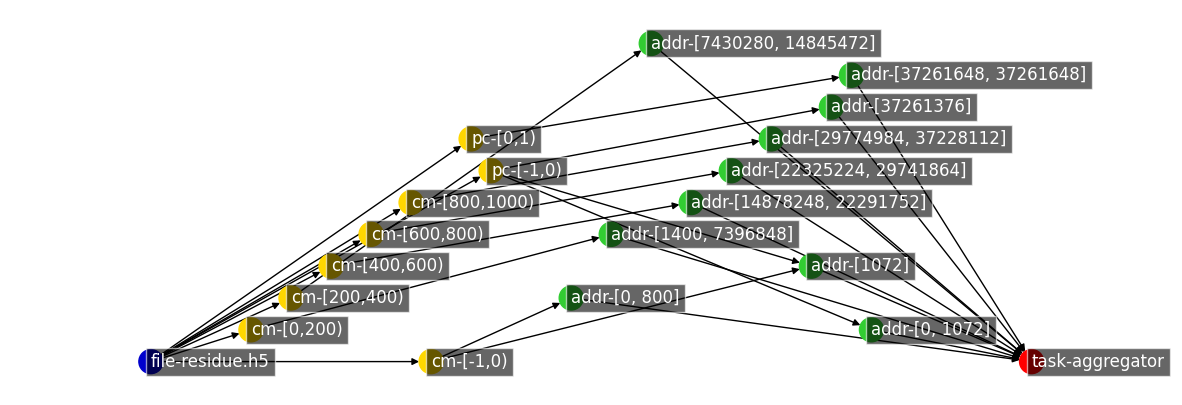

In [884]:
fagg_read='../sankey_diagram/dataframes/prov-vfd-agg-read-merged.csv'

df_agg_read_merged = read_data(fagg_read)

x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0]
df_agg_read_merged = map_split_tags(df_agg_read_merged,GROUP_CNT,x_pos)
print(df_agg_read_merged.columns)

G_AGG_R = nx.DiGraph()

add_edges_one2many(G_AGG_R,df_agg_read_merged, 'residue.h5', 'group_vol', x_pos=x_pos, tags=['file','agg_r-vol'])
# add_edges_many2many(G_AGG_R,df_agg_read_merged, 'group_vol', 'group_vfd', x_pos=x_pos, tags=['agg_r-vol','agg_r-addr'])
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0] +1
add_edges_many2one(G_AGG_R,df_agg_read_merged, 'group_vfd', 'aggregator', x_pos=x_pos, tags=['agg_r-addr','task'])

add_edges_many2many(G_AGG_R,df_agg_read_merged, 'group_vol', 'group_vfd', tags=['agg_r-vol','agg_r-addr'])

# x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0] + PADDING
# add_edges_many2many(G_AGG_R,df_agg_read_merged, 'group_vfd', 'group_vol', x_pos=x_pos, tags=['agg_r-addr','agg_r-vol'])



print(nx.get_node_attributes(G_AGG_R,'pos'))
print(G_AGG_R.nodes)

draw_graph(G_AGG_R,COLOR_MAP, rm_tags=['agg_r'])

{'contact_map-[-1,0)': '[0, 195]', 'contact_map-[-1,0)-1': '[463]', 'contact_map-[0,200)': '[491, 26827037]', 'contact_map-[200,400)': '[7413371, 34280461]', 'contact_map-[400,600)': '[14861339, 37262337]', 'contact_map-[600,800)': '[22317597, 37265537]', 'contact_map-[800,1000)': '[29770557, 37268737]', 'point_cloud-[-1,0)': '[0, 37260149]', 'point_cloud-[-1,0)-1': '[37268753]', 'point_cloud-[0,1)': '[37268781, 39674399]'}
{'[0, 195]': 1, '[0, 37260149]': 2, '[14861339, 37262337]': 3, '[22317597, 37265537]': 4, '[29770557, 37268737]': 5, '[37268753]': 6, '[37268781, 39674399]': 7, '[463]': 8, '[491, 26827037]': 9, '[7413371, 34280461]': 10}
Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'logical_addr_vol', 'op_type_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'logical_addr_vfd', 

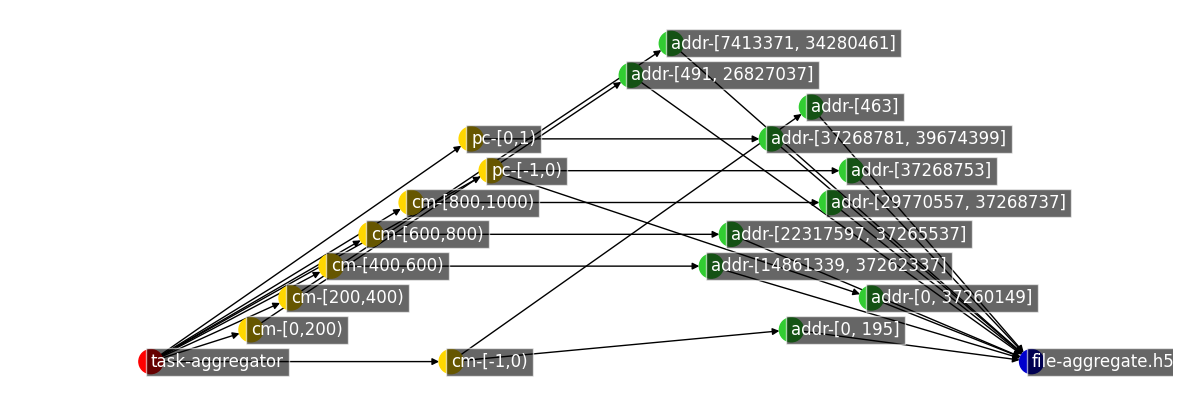

In [885]:
fagg_write='../sankey_diagram/dataframes/prov-vfd-agg-write-merged.csv'

df_agg_write_merged = read_data(fagg_write)
# print(list(df_agg_write_merged['logical_addr_vfd']))
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0]
df_agg_write_merged = map_split_tags(df_agg_write_merged,GROUP_CNT,x_pos)

print(df_agg_write_merged.columns)

G_AGG_W = nx.DiGraph()
add_edges_one2many(G_AGG_W,df_agg_write_merged, 'aggregator', 'group_vol', x_pos=x_pos, tags=['task','agg_w-vol'])
x_pos = max(nx.get_node_attributes(G_AGG_W,'pos').values())[0] +1
add_edges_many2one(G_AGG_W,df_agg_write_merged, 'group_vfd', 'aggregate.h5', x_pos=x_pos, tags=['agg_w-addr','file'])
add_edges_many2many(G_AGG_W,df_agg_write_merged, 'group_vol', 'group_vfd', tags=['agg_w-vol','agg_w-addr'])

draw_graph(G_AGG_W,COLOR_MAP,rm_tags=['agg_w'])


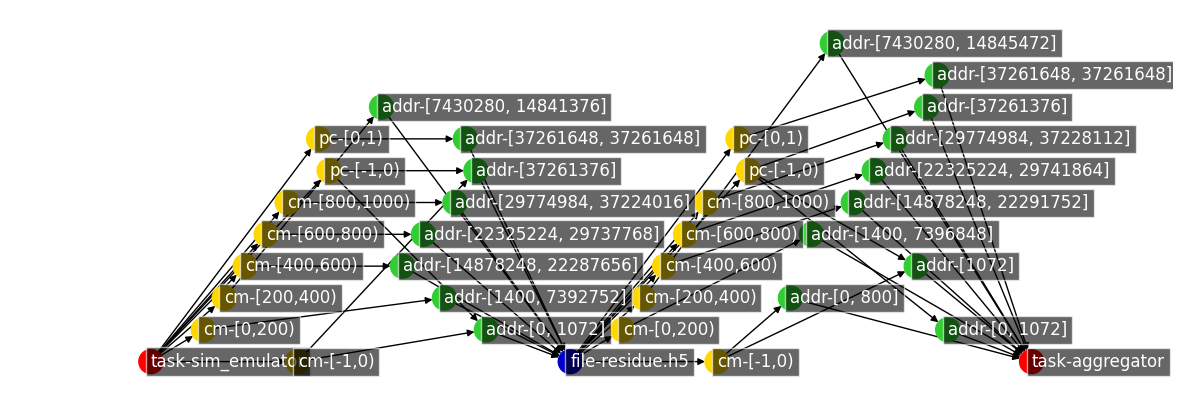

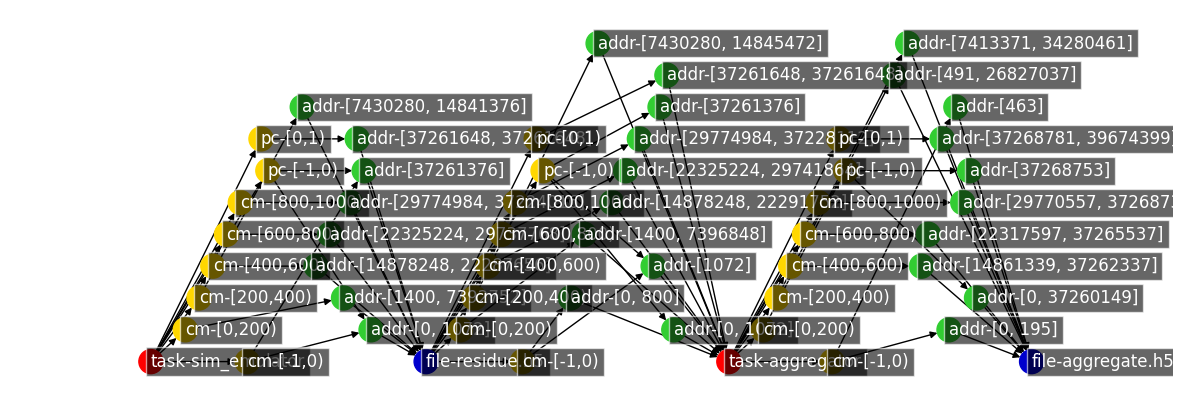

In [886]:
F1 = nx.compose(G_SIM,G_AGG_R)
draw_graph(F1,COLOR_MAP,rm_tags=['sim','agg_r'])

F2 = nx.compose(F1, G_AGG_W)
draw_graph(F2,COLOR_MAP,rm_tags=['sim','agg_r','agg_w'])

In [893]:
# Sankey related codes
def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    # shift x position to start from 0
    x_base= min(x_dict.values())
    x_dict = {k: v-x_base for k, v in x_dict.items()}

    # normalize x and y position
    xf=1.0/(max(x_dict.values()))
    x_pos = {k: v*xf for k, v in x_dict.items() }
    
    yf=1.0/max(y_dict.values())
    y_pos = {k: v*yf for k, v in y_dict.items() }
    
    
    return x_pos, y_pos

def get_nodes_for_sankey(G, rm_tags=[],label_on=True):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        node_type = attr['name']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        if label_on :  node_dict_for_sankey['label'].append(rm_name_tags(node_name,rm_tags))
        node_dict_for_sankey['color'].append(COLOR_MAP[rm_name_tags(node_type,rm_tags)])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref


def edge_color_scale(attr_bw, attr_op, bw, op):
    range = 100

    base_color_dict = {}
    if op in EDGE_COLOR_RGBA.keys():
        base_color_dict = EDGE_COLOR_RGBA[op]
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
    else:
        base_color_dict = EDGE_COLOR_RGBA['none']
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
        color_str = f"rgba({r}, {g}, {b}, {OPACITY})"
        return color_str

    edges = []
    for k,v in attr_op.items():
        if v == op:
            edges.append(k)
    # bw_list = list(set(attr_bw.values()))
    bw_list = [attr_bw[x] for x in edges]
    bw_list.sort()
    # print(bw_list)
        
    color_ranks = stats.rankdata(bw_list,method='dense')
    color_ranks = [float(i)/max(color_ranks) for i in color_ranks] # normalize

    my_rank = color_ranks[bw_list.index(bw)]

    color_change = my_rank *range #(my_rank-1)
    op_change = (my_rank/max(color_ranks)) * 0.5 + 0.4
    color_str = f"rgba({r-color_change/1.5}, {g-color_change/1.5}, {b-color_change/1.5}, {op_change})"

    # print(f"{color_str} rank={my_rank} sqrt={math.sqrt(my_rank)} change={color_change}")
    return color_str

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation','bandwidth'],rm_tags=[]):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': []}
    #'hoverinfo': "all"
    #'line_width':[], # shows strokeWidth of the edges
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    attr_bw = nx.get_edge_attributes(G,edge_attr[3])
    
    min_size = min(attr_size.values())
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)

        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        graph_size = size
        
        if cnt == 0: cnt = 1
        if size == 0: graph_size = 1
        
        op = attr_op[(u,v)]

        # get edge color based on bandwidth
        link_dict_for_sankey['value'].append(graph_size)
        # _str = f"ave_acc_size: {humansize(size/cnt)} op: {op}"
        bw = attr_bw[(u,v)]
        _str = (f"Access Volume : {humansize(size)} <br />"
            + f"Access Count : {cnt} <br />"
            + f"Average Access Size : {humansize(size/cnt)} <br />"
            + f"Operation : {op}<br />"
            +f"Bandwidth : {humanbw(bw)}")
        
        link_dict_for_sankey['label'].append(_str)

        link_dict_for_sankey['color'].append(edge_color_scale(attr_bw, attr_op, bw, op)) # get the last operation
        # link_dict_for_sankey['acc_cnt'].append(cnt)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [906]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM, rm_tags=['sim'], label_on=False)

# print(node_ref2)

sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)
fig = go.Figure(go.Sankey(
            node = sim_nodes,
            link = sim_links, orientation='h'))


fig.update_layout(
    autosize=False,
    width=600,
    height=200,
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=10,
        pad=2
    ),
)
fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-sim-thumbnail-vol-vfd-.html")

In [894]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM, rm_tags=['sim'])

# print(node_ref2)

sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)
fig = go.Figure(go.Sankey(
            node = sim_nodes,
            link = sim_links, orientation='h'))


fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=10,
        pad=2
    ),
)
fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-sim-vol-vfd-.html")

In [895]:

agg_r_nodes, agg_r_nodes_dict = get_nodes_for_sankey(G_AGG_R, rm_tags=['agg_r'])

print(nx.get_node_attributes(G_AGG_R,'pos'))
# print(node_ref2)

agg_r_links = get_links_for_sankey(G_AGG_R, agg_r_nodes_dict)
fig = go.Figure(go.Sankey(
            node = agg_r_nodes,
            link = agg_r_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=10,
        pad=2
    ),
)
fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-agg_r-vol-vfd-.html")

{'file-residue.h5': (40, 0), 'agg_r-vol-contact_map-[-1,0)': (54, 0), 'agg_r-vol-contact_map-[0,200)': (45, 1), 'agg_r-vol-contact_map-[200,400)': (47, 2), 'agg_r-vol-contact_map-[400,600)': (49, 3), 'agg_r-vol-contact_map-[600,800)': (51, 4), 'agg_r-vol-contact_map-[800,1000)': (53, 5), 'agg_r-vol-point_cloud-[-1,0)': (57, 6), 'agg_r-vol-point_cloud-[0,1)': (56, 7), 'agg_r-addr-[0, 800]': (61, 2), 'agg_r-addr-[1072]': (73, 3), 'agg_r-addr-[1400, 7396848]': (63, 4), 'agg_r-addr-[7430280, 14845472]': (65, 10), 'agg_r-addr-[14878248, 22291752]': (67, 5), 'agg_r-addr-[22325224, 29741864]': (69, 6), 'agg_r-addr-[29774984, 37228112]': (71, 7), 'agg_r-addr-[0, 1072]': (76, 1), 'agg_r-addr-[37261648, 37261648]': (75, 9), 'agg_r-addr-[37261376]': (74, 8), 'task-aggregator': (84, 0)}


In [896]:
agg_w_nodes, agg_w_nodes_dict = get_nodes_for_sankey(G_AGG_W, rm_tags=['agg_w'])

# print(node_ref2)

agg_w_links = get_links_for_sankey(G_AGG_W, agg_w_nodes_dict)
fig = go.Figure(go.Sankey(
            node = agg_w_nodes,
            link = agg_w_links, orientation='h'))


fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=10,
        pad=2
    ),
)

fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-agg_w-vol-vfd-.html")

In [897]:
AGG = nx.compose(G_AGG_R, G_AGG_W) 

agg_nodes, agg_nodes_dict = get_nodes_for_sankey(AGG,rm_tags=['agg_r','agg_w'])

agg_links = get_links_for_sankey(AGG, agg_nodes_dict)
fig = go.Figure(go.Sankey(
            node = agg_nodes,
            link = agg_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=2000,
    height=400,
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=10,
        pad=2
    ),
)
fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-agg-vol-vfd.html")

In [898]:
f2_nodes, f2_nodes_dict = get_nodes_for_sankey(F2,rm_tags=['sim','agg_r','agg_w'],label_on=False)

# print(node_ref2)

f2_links = get_links_for_sankey(F2, f2_nodes_dict)
fig = go.Figure(go.Sankey(
            node = f2_nodes,
            link = f2_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    margin=dict(
        l=10,
        r=10,
        b=40,
        t=10,
        pad=4
    ),
)
fig.show()
fig.write_html(f"{IMAGE_PATH}/sankey-grouped-sim_agg-vol-vfd.html")